In [89]:
import os
import sys
import numpy as np
import PIL
from PIL import Image
import torch
# Append custom paths to sys.path for importing custom modules
sys.path.append(os.path.dirname("/home/student/Desktop/31171109-donotdelete/xai-chan/utils"))
from utils.models import ResNet_Model
from utils.transform import resize_transform

# Initialize device
device = torch.device('cuda:0')

#MODEL PATH
weights_path = "/home/student/Desktop/31171109-donotdelete/xai-chan/result/imagenet/_Fold_2_5_400X_BreakHis_FT_60_resnet50_imagenet_/_37_96.07250755287009_95.06917631917632_0.9614846110343933.pth"  # TODO: Provide the model path
#IMAGE PATH
image_path ="/home/student/Desktop/31171109-donotdelete/xai-chan/dataset/Fold_4_5/val_10/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-001.png"
saved_path = '/home/student/Desktop/31171109-donotdelete/xai-chan/explanation/explanation/SOB_M_PC-14-15687B-400-005-heatmap.png'

In [90]:
# Load model
version = 50
downstream_task_model = ResNet_Model(version=version).to(device)
downstream_task_model.load_state_dict(torch.load(weights_path, map_location=device))
downstream_task_model.eval()

/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [91]:
input_rgb = Image.open(image_path)
input_size= input_rgb.size
# print(f"Width: {width}, Height: {height}")
input_tensor = resize_transform(np.array(input_rgb)).unsqueeze(0).to(device)
print(input_tensor)
outputs = downstream_task_model(input_tensor)
print(outputs)
target_category = (outputs > 0.2).int().item()
print(target_category)

tensor([[[[0.9333, 0.9569, 0.9765,  ..., 0.9059, 0.8863, 0.8196],
          [0.9176, 0.9647, 0.9804,  ..., 0.8902, 0.8706, 0.7961],
          [0.8980, 0.9490, 0.9490,  ..., 0.8784, 0.8510, 0.7686],
          ...,
          [0.8118, 0.8314, 0.8392,  ..., 0.8863, 0.8745, 0.8706],
          [0.7529, 0.7686, 0.7843,  ..., 0.8824, 0.8784, 0.8706],
          [0.7137, 0.7490, 0.7529,  ..., 0.8863, 0.8784, 0.8667]],

         [[0.7137, 0.6941, 0.6863,  ..., 0.4667, 0.4510, 0.4431],
          [0.6941, 0.6980, 0.6863,  ..., 0.4431, 0.4275, 0.4118],
          [0.6667, 0.6745, 0.6471,  ..., 0.4196, 0.3922, 0.3804],
          ...,
          [0.4745, 0.4549, 0.4471,  ..., 0.8627, 0.8627, 0.8549],
          [0.4275, 0.4078, 0.4039,  ..., 0.8588, 0.8588, 0.8588],
          [0.4039, 0.3922, 0.3804,  ..., 0.8627, 0.8627, 0.8549]],

         [[0.8706, 0.8863, 0.9020,  ..., 0.6627, 0.6588, 0.6549],
          [0.8471, 0.8824, 0.8941,  ..., 0.6471, 0.6431, 0.6275],
          [0.8078, 0.8588, 0.8510,  ..., 0

In [101]:
from zennit.image import imgify, imsave  # For creating visualizations
from zennit.torchvision import ResNetCanonizer  # For ResNet-specific canonization
from zennit.composites import EpsilonPlusFlat,EpsilonAlpha2Beta1,EpsilonAlpha2Beta1Flat  # For the composite function in LRP
from zennit.attribution import Gradient  # For attributing using gradients
from IPython.display import display
# Make sure  model is in evaluation mode
downstream_task_model.eval()

# Use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# Create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

target = torch.tensor([[target_category]]).float().to(device)


# Create the attributor, specifying model and composite
with Gradient(model=downstream_task_model, composite=composite) as attributor:
    # Compute the model output and attribution
    output, attribution = attributor(input_tensor, target)

print(f'Prediction: {output.item()}')  # Adapted for a binary classification output

# Sum over the channels
relevance = attribution.sum(1).cpu()

# Create an image of the visualized attribution
img = imgify(relevance, symmetric=True, cmap="coldnhot")
heatmap_resized = img.resize(input_size)

# Convert the image to RGB mode and then display it
heatmap_resized.convert('RGB').show()

# Show the image
# directly save the visualized attribution
# imsave(saved_path, heatmap_resized, format='PNG',cmap='coldnhot')

Prediction: 0.9990164041519165


In [95]:
from sklearn.metrics import roc_auc_score, roc_curve
# Rank pixels by importance
relevance_values = relevance.view(-1).detach().numpy()
sorted_indices = np.argsort(-np.abs(relevance_values))  # negative for descending order

# For simplicity, let's say you want to obscure in steps of 10% of pixels
steps = np.linspace(0, 1, 11)

tp_rates = []
fp_rates = []

for step in steps:
    num_pixels_to_occlude = int(step * relevance.numel())
    indices_to_occlude = sorted_indices[:num_pixels_to_occlude]

    # Create a copy of the original image
    occluded_image = input_tensor.clone()

    # Set occluded pixels to neutral value, for example, the mean value
    occluded_image.view(-1)[indices_to_occlude] = occluded_image.mean()

    # Classify occluded image
    with torch.no_grad():
        prediction = downstream_task_model(occluded_image).item()
    
    # Record TPR and FPR; for simplicity assuming binary classification
    # and that target class 1.0 is the positive class
    if target.item() == 1.0:
        tp_rates.append(prediction)
        fp_rates.append(1 - prediction)
    else:
        fp_rates.append(prediction)
        tp_rates.append(1 - prediction)

y_true = [target_category] * len(tp_rates)
print(y_true)
# If your target_category is 1, use tp_rates, else use fp_rates as y_pred
y_pred = tp_rates if target_category == 1 else fp_rates

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)



print(f'AUC: {auc}')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

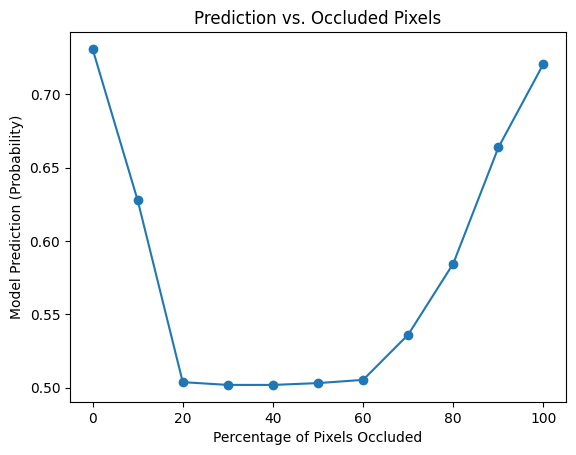

In [102]:
relevance_values = relevance.view(-1).detach().numpy()
sorted_indices = np.argsort(-np.abs(relevance_values))
steps = np.linspace(0, 1, 11)

predicted_probs = []

for step in steps:
    num_pixels_to_occlude = int(step * relevance.numel())
    indices_to_occlude = sorted_indices[:num_pixels_to_occlude]
    occluded_image = input_tensor.clone()
    occluded_image.view(-1)[indices_to_occlude] = occluded_image.mean()

    with torch.no_grad():
        prediction = torch.sigmoid(downstream_task_model(occluded_image)).item()
    predicted_probs.append(prediction)

import matplotlib.pyplot as plt
plt.plot(steps * 100, predicted_probs, '-o')
plt.xlabel('Percentage of Pixels Occluded')
plt.ylabel('Model Prediction (Probability)')
plt.title('Prediction vs. Occluded Pixels')
plt.show()


In [103]:
# Compute the AOC for LRP
cumulative_sum = np.cumsum(np.sort(relevance_values))
aoc = cumulative_sum[-1] / (relevance.numel() * relevance_values.max())
print(f"AOC for LRP: {aoc:.4f}")


AOC for LRP: 0.0251


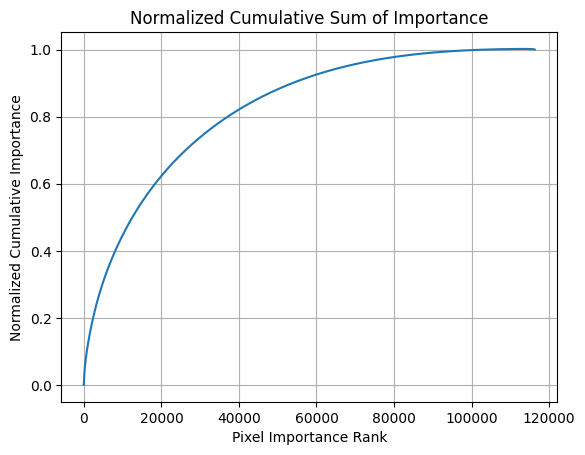

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_cumulative_sum(heatmap):
    # Flatten the heatmap
    flat_heatmap = heatmap.flatten()
    
    # Sort the flattened heatmap in descending order
    sorted_heatmap = np.sort(flat_heatmap)[::-1]
    
    # Compute the cumulative sum
    cum_sum = np.cumsum(sorted_heatmap)
    
    # Normalize the cumulative sum
    normalized_cum_sum = cum_sum / cum_sum[-1]
    
    # Plot
    plt.plot(normalized_cum_sum)
    plt.xlabel('Pixel Importance Rank')
    plt.ylabel('Normalized Cumulative Importance')
    plt.title('Normalized Cumulative Sum of Importance')
    plt.grid(True)
    plt.show()
# Convert relevance to a numpy array and pass to the function
relevance_np = relevance.cpu().numpy()
plot_normalized_cumulative_sum(relevance_np)
